<a href="https://colab.research.google.com/github/lucinnnal/Attention-is-all-you-need-scratch/blob/main/Attention_is_All_You_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Multi-head attention
class MultiheadAttention(nn.Module):
  def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
    super().__init__()

    assert hidden_dim % n_heads == 0 # 각 head에서 나오는 차원이 hidden dim(모델로 들어오는 시퀀스 백터의 차원) / head의 개수로 되어야함. hidden dim // n_heads == 0 이 아니라면 오류, 이 후 각 head에서 나오는 결과값을 concat 해주어서 원래의 hidden_dim으로 돌려놓을 것임.
    self.hidden_dim = hidden_dim # embeddiing dimension
    self.n_heads = n_heads # num of heads in multi-head self-attention
    self.head_dim = hidden_dim / n_heads # embedding dimension in each head

    # Query, Key, and Value
    self.fc_q = nn.Linear(hidden_dim, hidden_dim)
    self.fc_k = nn.Linear(hidden_dim, hidden_dim)
    self.fc_v = nn.Linear(hidden_dim, hidden_dim)
    # 추후에 head-dimension 으로 변경시켜 줄 것임.

    # output 나오기 전에 fc_layer 거칠 것임
    self.fc_o = nn.Linear(hidden_dim, hidden_dim)

    # Dropout Ratio
    self.dropout = nn.Dropout(dropout_ratio)

    # The amount of the scaling (얼마나 나누어 줄 것 인지)
    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device) # 이는 scaling 값을 정의하는 텐서 (dimension of key)

  def forward(self, query, key, value, mask = None):

    batch_size = query.shape[0]

    # query, key, value shape : [batch_size, sequence_len(query, key, value), hidden_dim]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)
    # Q, K, V shape : [batch_size, sequence_len(Q, K, V), hidden_dimension]

    # query, key value 를 각각 head dimension 들로 쪼개줄 것임 : hidden_dimension -> head_dimension * n_heads
    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
    # Q: [batch_size, n_heads, query_len, head_dim]
    # K: [batch_size, n_heads, key_len, head_dim]
    # V: [batch_size, n_heads, value_len, head_dim]

    # Attention Energy
    energy = torch.matmul(Q, K.permute(0,1,3,2)) / self.scale
    # energy = [batch_size, n_heads, query_len, key_len]

    # Mask
    if mask != None:
      energy = energy.masked_fill(mask==0, -1e10) # masked_fill 조건에 맞는 위치를 특정값으로 (여기서는 mask가 0인 위치를 -1e10으로 채워준다) -> 음의 무한에 가까운 수를 주어 softmax를 통과하면 0에 가까운 값을 가져 그 부분은 무시될 수 있도록!

    # Attention Scores
    attention = torch.softmax(energy, dim=-1)

    # attention = [batch_size, n_heads, query_len, key_len] -> 각 query 당 key들이 얼마나 연관성이 높은지를 나타냄

    # attention scores * values
    x = torch.matmul(self.dropout(attenion), V) # 여기서 dropout은 일부 attention score를 0으로 보내버림.

    # x shape = [batch_size, n_heads, query_len, head_dim]
    # contiguous? : memory의 연속적인 공간으로 텐서를 할당(view는 메모리 공간이 연속적인 탠서에 대해 가능(연속적이지 않은 tensor에 대해 view? : 오류) 따라서 permute나 transpose를 시켜준 이 후에 view를 사용하기전 contiguouos를 이용하면 됨)
    x = x.permute(0,2,1,3).contiguous()

    x = x.view(batch_size, -1, self.hidden_dim) # 모든 head 들로부터 나온 값을 view 를 통해 합치기

    # x shape = [batch_size, query_len, hidden_dim]

    # FC_Layer 통과
    x = self.fc_o(x)

    return x, attention # 결론적으로 모든 단어에 대한 multihead attention 결과값과 , attention score를 반환

# **Mask**
GPT:
여기서 energy shape 은 [batch_size, n_heads, query_len, key_len] 이고 mask shape 은 batch_size, key_len 이야 broadcasting 이 적용돼?

ChatGPT의 말:
ChatGPT
네, 여기서 broadcasting이 적용됩니다. energy 텐서의 shape이 [batch_size, n_heads, query_len, key_len]이고 mask의 shape이 [batch_size, key_len]인 경우, PyTorch에서는 broadcasting을 통해 두 텐서의 크기를 맞추어 연산할 수 있습니다.

구체적으로는 mask 텐서가 [batch_size, 1, 1, key_len]로 확장(broadcast)되어 energy 텐서와 element-wise 비교가 가능해집니다. Broadcasting의 원리에 따라 mask가 자동으로 확장되므로, 각 query_len과 n_heads 차원에서 동일한 mask가 적용됩니다.

이렇게 되면 각 query 위치에서 mask가 0인 위치는 -1e10으로 채워져 softmax 연산에서 무시되도록 처리됩니다.

# 예제 4차원 텐서 생성: shape (batch, channels, height, width)
tensor = torch.randn(8, 3, 64, 64)  # 예시로 배치 크기 8, 채널 3, 높이 64, 너비 64

# 차원 순서를 (0, 2, 3, 1)로 변경: 결과 shape (batch, height, width, channels)
transposed_tensor = tensor.permute(0, 2, 3, 1)
print(transposed_tensor.shape)  # 출력: torch.Size([8, 64, 64, 3])


Dropout?


여기서 dropout 은 attention score 일부를 0으로 만든다야?



ChatGPT의 말:
ChatGPT
맞습니다! 여기서 dropout은 attention score의 일부를 0으로 만들어 regularization을 적용하는 역할을 합니다. 이 과정은 attention score에서 일부 값들을 무작위로 0으로 만들어서 모델이 특정 입력에 과도하게 의존하지 않도록 합니다. 이를 통해 모델의 일반화 능력을 향상시킬 수 있습니다.


예를 들어, 기계 번역에서 "I am a student"라는 문장이 주어지고, 목표 출력은 "Je suis un étudiant"인 경우:

인코더는 "I am a student"를 입력받아 이를 벡터로 변환합니다.
디코더는 "Je"를 첫 번째 입력으로 받아 "suis"를 예측하고, "Je suis"를 입력으로 받아 "un"을 예측하는 방식으로 진행됩니다.

In [ ]:
# Position-wise Feed Forward
class PositionwiseFeedForward(nn.Module):
  def __init__(self, hidden_dim, pf_dim, dropout_rate):
    super().__init__()
    self.dropout = nn.Dropout(dropout_rate)
    self.fc_layer1 = nn.Linear(hidden_dim, pf_dim)
    self.fc_layer2 = nn.Linear(pf_dim, hidden_dim)

  def forward(self, x):

    # FFN(x) = max(0, xW1 + b1)W2 + b2
    # input x shape = [batch_size, seq_len, hidden_dimension]
    x = torch.ReLU(self.fc_layer1(x))
    # x shape after fc_layer1 = [batch_size, seq_len, pf_dimension]
    x = self.dropout(x)
    x = self.fc_layer2(x)
    # x shape after feed forward -> [batch_size, seq_len, hidden_dimension]
    return x

nn.LayerNorm은 PyTorch에서 주어진 텐서의 마지막 차원에 대해 layer normalization을 수행하는 모듈입니다. 이 함수는 주로 딥러닝 모델의 hidden layers의 출력을 정규화하여 학습 안정성을 높이고 성능을 개선하는 데 사용됩니다.

여기서 hidden_dim은 layer normalization을 적용할 대상 텐서의 마지막 차원의 크기를 의미합니다. 예를 들어, 만약 모델의 hidden state 벡터가 (batch_size, sequence_length, hidden_dim) 모양이라면, nn.LayerNorm(hidden_dim)은 각 hidden state 벡터에 대해 정규화를 수행합니다.

Layer Normalization의 일반적인 사용 예시는 다음과 같습니다:

python
코드 복사
import torch
import torch.nn as nn

hidden_dim = 512  # 예시로 512 차원의 hidden layer라고 가정
layer_norm = nn.LayerNorm(hidden_dim)

# 임의의 입력 텐서 예시
x = torch.randn(10, 20, hidden_dim)  # (batch_size, sequence_length, hidden_dim)
normalized_x = layer_norm(x)
이 코드에서 layer_norm(x)을 호출하면 x의 각 벡터가 평균 0, 분산 1로 정규화된 텐서가 반환됩니다.

src_mask -> input 에서 <pad> 처리 되어있는 것들은 0으로 만들어 마스크 처리 -> 참조하지 못하게

In [ ]:
# A single Encoder Layer
class EncoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_rate, device):
    super().__init__()
    self.self_attention = MultiheadAttention(hidden_dim, n_heads, dropout_rate, device)
    self.feedforwardlayer = PositionwiseFeedForward(hidden_dim, pf_dim, dropout_rate)
    self.dropout = nn.Dropout(dropout_rate)
    # layernorms are conducted after self_attention and feed forward
    self.attention_layer_norm = nn.LayerNorm(hidden_dim)
    self.feed_forward_layer_norm = nn.LayerNorm(hidden_dim)
  # One input embedding will be copied and go in to Key, Query and value
  def forward(self, source, source_mask):
    # source shape = [batch_size, sequence_len, hidden_dim = embedding dimension] # here the source is already embedded
    # source mask = [batch_size, source_len]

    # attention
    _source,_ = self.self_attention(source, source, source, source_mask) # query key value는 복제되어 전달되며 각각의 query key value 는 nn.Linear를 거쳐 똑같은 source로 부터 생성됨.

    # residual coonection + layer_norm (+dropout)
    source = self.attention_layer_norm(source + self.dropout(_source))

    # source shape = [batch_size, sequence_len, hidden_dim]

    # feed forward
    _source = self.feedforwardlayer(source)

    # residual connection + layer_norm (+dropout)
    source = self.feed_forward_layer_norm(source + self.dropout(_source))

    #source shape = [batch_size, sequence_len, hidden_dim]

    return source

nn.Embedding 과 nn.Linear는 다름 -> nn.Linear는 특정차원에서 다른 차원으로 선형변환을 목적으로 하는 것이지만, nn.Embedding은 특정 크기에서 정의된 index의 차원을 늘려주는것
(예를 들어, 단어의 사전이 1000개의 인덱스를 가지고 있다면, 이 1000개의 index들을 고려하여 각 인덱스를 고차원의 백터로 표현하는 것)



GPT:

`nn.Linear`와 `nn.Embedding`은 모두 PyTorch에서 제공하는 신경망 계층이지만, 그 기능과 목적은 다릅니다.

1. **`nn.Linear`**:
   - `nn.Linear`는 완전 연결층(fully connected layer)입니다. 주로 입력 텐서에 대해 선형 변환을 수행합니다.
   - 수학적으로는 \( y = Ax + b \) 형태의 연산을 합니다. 여기서 \( A \)는 가중치 행렬, \( b \)는 편향 벡터, \( x \)는 입력 벡터입니다.
   - 입력과 출력 크기(shape)는 직접 지정해야 합니다.
   - 예: `nn.Linear(in_features, out_features)`로 정의하며, 입력 차원 `in_features`에 대해 출력 차원 `out_features`를 설정합니다.

2. **`nn.Embedding`**:
   - `nn.Embedding`은 주로 자연어 처리(NLP)에서 사용되며, 고정된 크기의 임베딩 벡터를 사용하여 각 단어 또는 인덱스를 고차원 벡터로 변환하는 역할을 합니다.
   - 입력값은 정수 인덱스이며, 각 인덱스에 해당하는 벡터를 가져오는 방식으로 작동합니다. 즉, `nn.Embedding`은 단어, 토큰 등의 인덱스를 고차원 공간의 벡터로 매핑합니다.
   - 예: `nn.Embedding(num_embeddings, embedding_dim)`에서 `num_embeddings`는 임베딩의 개수(보통 단어의 개수)이고, `embedding_dim`은 각 단어가 매핑될 벡터의 차원입니다.

따라서, `nn.Linear`는 선형 변환을 위한 계층이고, `nn.Embedding`은 인덱스를 고차원 벡터로 매핑하는 임베딩 계층으로, 그 목적과 사용 방법이 다릅니다.

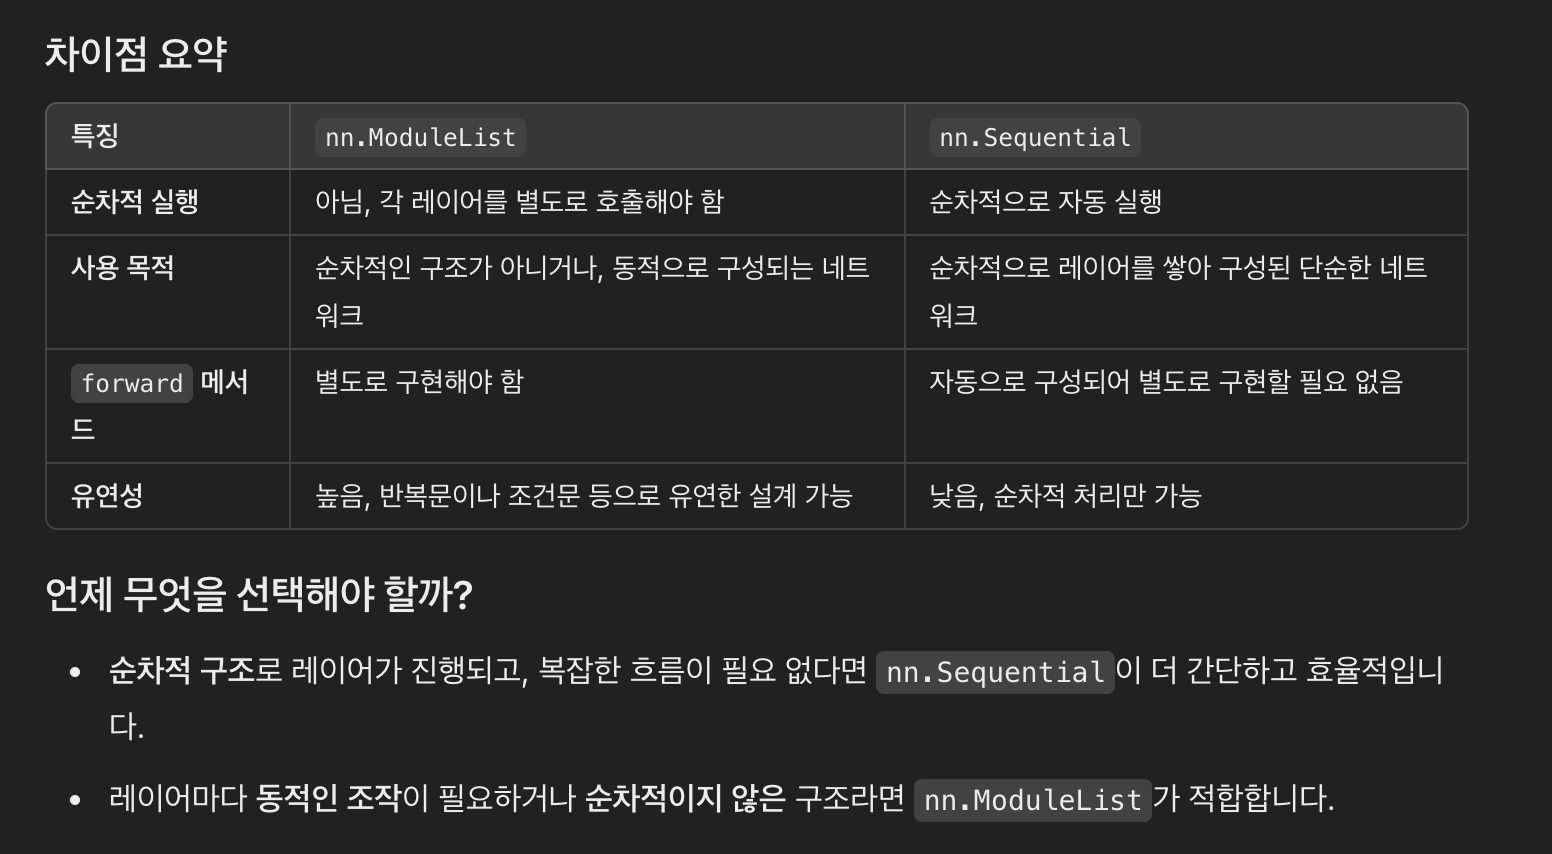

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token] -> src_pad_idx 는 단어 사전에서 pad 토큰이 정의된 인덱스 -> 0

In [ ]:
# Encoder
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, n_heads, n_layers, pf_dim, device, dropout_rate ,max_length = 100):
    super().__init__()

    self.device = device

    self.tok_embedding = nn.Embedding(input_dim, hidden_dim) # word embedding
    self.pos_embedding = nn.Embedding(max_length, hidden_dim) # positional embedding

    self.layers = nn.Modulist([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_rate, device) for _ in range(n_layers)])

    self.dropout = nn.Dropout(dropout_rate)

    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, src, src_mask):

    # src = [batch_size, len_sequence]
    # src_mask = [batch_size, len_sequence]

    batch_size = src.shape[0]
    src_len = src.shape[1]

    # defining positional encoding : shape = [batch_size, src_len]
    pos = torch.arange(0, src_len).unsqueeze(0).repeat(1, batch_size).to(self.device)

    src = self.dropout(self.tok_embedding(src) * self.scale + self.pos_embedding(pos))

    for layer in self.layers:
      src = layer(src, src_mask)

    # src_shape = [batch_size, src_len, hidden_dimension]

    return src

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_rate, device):
    super().__init__()

    self.masked_multihead = MultiheadAttention(hidden_dim, n_heads, dropout_rate, device) #first multihead
    self.multihead = MultiheadAttention(hidden_dim, n_heads, dropout_rate, device) #second multihead
    self.layernorm_aftermaskedatt = nn.LayerNorm(hidden_dim) #layer norm after masked
    self.layernorm_att = nn.LayerNorm(hidden_dim) #layer norm after attention
    self.ff_layer_norm = nn.LayerNorm(hidden_dim) #layer norm after feed forward
    self.positionwise_feedforward = PositionwiseFeedForward(hidden_dim, pf_dim, dropout_rate) # PFF
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, trg, enc_src, trg_mask, src_mask):

    # trg = [batch_size, seq_len, hidden_dim]
    # enc_src = [batch_size, seq_len, hidden_dim]
    # trg_mask = [batch_size, trg_len]
    # src_mask = [batch_size, src_len]

    _trg, _ = self.masked_multihead(trg, trg, trg, trg_mask)
    trg = self.layernorm_aftermaskedatt(trg + self.dropout(_trg)) # (connection and dropout) + layernormalization

    _trg, attention = self.multihead(trg, enc_src, enc_src, src_mask)
    trg = self.layernorm_att(trg + self.dropout(_trg))

    _trg = self.positionwise_feedforward(trg)
    trg = self.ff_layer_norm(trg + self.dropout(_trg))


    return trg, attention

In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length = 100):
    super().__init__()

    self.device = device

    self.tok_embedding = nn.Embedding(output_dim, hidden_dim) # embedding the word indexes into a hidden_dimension -> increasing the dimension from [batch size, seq_len] to [batch_size, seq_len, hidden_dim]
    self.pos_embedding = nn.Embedding(max_length, hidden_dim) # embedding the positional indexes into a hidden_dimension -> increasing the dimension from [batch size, seq_len] to [batch_size, seq_len, hidden_dim]
    # output_dim 은 인덱스의 범위 예를 들어 pos에서 0~100까지의 범위를 가진다면 이를 고려해 각각의 요소들을 고차원의 백터로 변환
    self.dropout = nn.Dropout(dropout_ratio)
    self.layers = nn.Modulelist([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(self.device)
    self.fc_out = nn.Linear(hidden_dim, output_dim)

  def forward(self, trg, enc_src, trg_mask, src_mask):

    batch_size = trg.shape[0]
    trg_len = trg.shape[1]

    pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

    # trg = [batchsize, trg_len]
    # pos = [batchsize, trg_len]

    trg = self.tok_embedding(trg)
    pos = self.pos_embedding(pos)

    # trg = [batchsize, trg_len, hidden_dim]
    # pos = [batchsize, trg_len, hidden_dim]

    trg = self.dropout(trg * self.scale + pos)

    for layer in self.layers:
      trg, attention = layer(trg, enc_src, trg_mask, src_mask)


    # trg = [batch_size, trg_len, hidden_dim]

    output = self.fc_out(trg)

    # output = [batch_size, trg_len, output_dim]

    return output, attention

In [ ]:
import torch

print(torch.arange(0,9).size())
print(torch.arange(0,9).unsqueeze(0).size())
print(torch.arange(0,9).unsqueeze(0).repeat(10,1).size())

torch.Size([9])
torch.Size([1, 9])
torch.Size([10, 9])


Masking for **target**

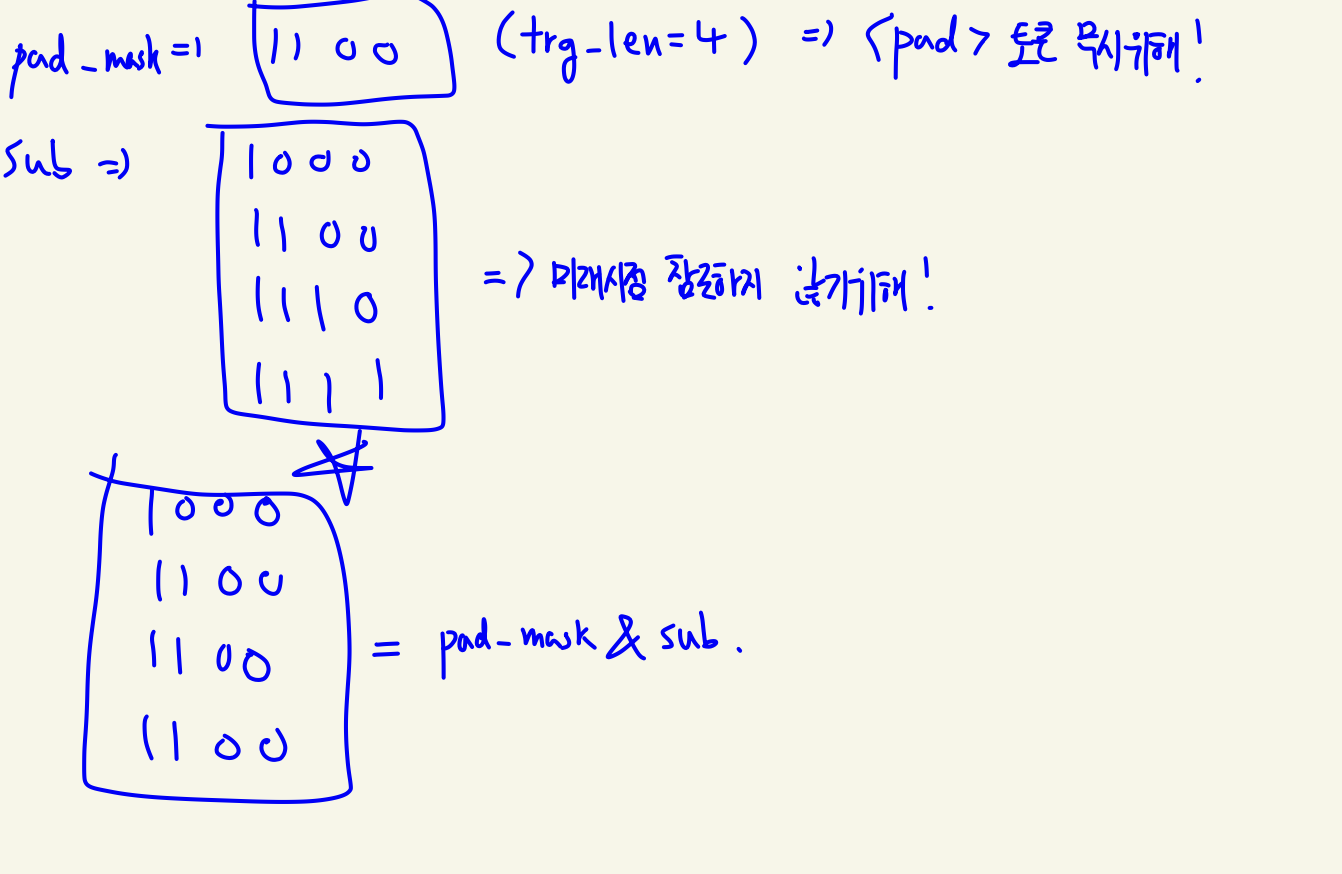

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_pad_idx = src_pad_idx # <pad> token의 index 값
    self.trg_pad_idx = trg_pad_idx # <pad> token의 index 값

    self.device = device

  def make_src_mask(self, src):
    # src = [batch_size, src_len]
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    # src_mask =[batch_size, 1, 1, src_len]
    return src_mask

  def make_trg_mask(self, trg):
    trg_len = trg.shape[1]
    trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2) # trg mask for masking <pad>s locations
    # trg_pad_mask =[batch_size, 1, 1, trg_len]
    trg_sub_mask = torch.trill(torch.ones(trg_len, trg_len), device = self.device).bool()

    # trg_sub_mask = [trg_len, trg_len]

    trg_mask = trg_pad_mask & trg_sub_mask

    return trg_mask

  def forward(self, src, trg):

    # src = [batch_size, src_len]
    # trg = [batch_size, trg_len]

    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)

    enc_src = self.encoder(src, src_mask)

    output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

    return output, attention